In [1]:
import numpy as np
from numpy import *

In [2]:
def loadSimpData():
    datamat = np.mat([[1.,2.1],
                     [2.,1.1],
                     [1.3,1.],
                     [1.,1.],
                     [2.,1.]])
    classLabels = [1.,1,-1,-1,1.]
    return datamat , classLabels

In [3]:
dataMat , classLabels = loadSimpData()

In [4]:
def stumpClassify(dataMatrix , dimen , threshVal,threshIneq):
    retArray = np.ones((dataMatrix.shape[0] ,1 ))
    if threshIneq == 'lt':
        retArray[dataMatrix[:,dimen] <= threshVal] = -1.0
    else:
        retArray[dataMatrix[:,dimen] > threshVal] = -1.0
    return retArray

In [5]:
def buildStump(dataArr , classLabels,D):
    dataMatrix = np.mat(dataArr)
    labelMat = np.mat(classLabels).T
    m , n  = dataMatrix.shape
    numSteps = 10.0
    bestStump = {}
    bestClassEst = np.mat(np.zeros((m,1)))
    minError = np.inf
    for i in range(n):
        rangeMin = dataMatrix[:,i].min()
        rangeMax = dataMatrix[:,i].max()
        stepSize = (rangeMax - rangeMin) / numSteps
        for j in range(-1,int(numSteps) + 1):
            for inequal in ['lt' , 'gt']:
                threshVal = (rangeMin + float(j) * stepSize)
                predicteVals = stumpClassify(dataMatrix , 
                                            i ,
                                            threshVal,
                                            inequal)
                errArr = np.mat(np.ones((m ,1)))
                errArr[predicteVals == labelMat] = 0
                weightedError = D.T * errArr
#                 print ("split: dim %d, thresh %.2f, \
#                         thresh ineqal: %s, \
#                         the weighted error is %.3f" % (i,
#                                                        threshVal,
#                                                        inequal, 
#                                                        weightedError))
                if weightedError < minError:
                    minError = weightedError
                    bestClasEst = predicteVals.copy()
                    bestStump['dim'] = i
                    bestStump['thresh'] = threshVal
                    bestStump['ineq'] = inequal
    return bestStump,minError,bestClasEst

In [6]:
D = np.mat(np.ones((5,1)) / 5)

In [7]:
buildStump(dataMat , classLabels ,D)

({'dim': 0, 'ineq': 'lt', 'thresh': 1.3}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [8]:
def adaBoostTrainDS(dataArr , classLabels , numTt=40):
    weakClassArr = []
    m = dataArr.shape[0]
    D = np.mat(np.ones((m,1))/m)
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numTt):
        bestStump , error , classEst = buildStump(dataArr , classLabels ,D)
        print('D : ',D.T)
        alpha = float(0.5 * np.log((1.0-error ) / max(error , 1e-16 )))
        bestStump['alphas'] = alpha
        weakClassArr.append(bestStump)
        print('classEst: ',classEst.T)
        expon = np.multiply(-1* alpha * np.mat(classLabels).T , classEst)
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        aggClassEst += alpha * classEst
        print("aggclassEst :" , aggClassEst.T)
        aggErrors = np.multiply(
                                np.sign(aggClassEst) != \
                                np.mat(classLabels).T , np.ones((m ,1)))
        errorRate = aggErrors.sum() / m
        print('total error :' ,errorRate ,'\n')
        if errorRate == 0.0: break
    return weakClassArr

In [9]:
classfierArray = adaBoostTrainDS(dataMat , classLabels ,9)

D :  [[0.2 0.2 0.2 0.2 0.2]]
classEst:  [[-1.  1. -1. -1.  1.]]
aggclassEst : [[-0.69314718  0.69314718 -0.69314718 -0.69314718  0.69314718]]
total error : 0.2 

D :  [[0.5   0.125 0.125 0.125 0.125]]
classEst:  [[ 1.  1. -1. -1. -1.]]
aggclassEst : [[ 0.27980789  1.66610226 -1.66610226 -1.66610226 -0.27980789]]
total error : 0.2 

D :  [[0.28571429 0.07142857 0.07142857 0.07142857 0.5       ]]
classEst:  [[1. 1. 1. 1. 1.]]
aggclassEst : [[ 1.17568763  2.56198199 -0.77022252 -0.77022252  0.61607184]]
total error : 0.0 



In [10]:
classfierArray

[{'alphas': 0.6931471805599453, 'dim': 0, 'ineq': 'lt', 'thresh': 1.3},
 {'alphas': 0.9729550745276565, 'dim': 1, 'ineq': 'lt', 'thresh': 1.0},
 {'alphas': 0.8958797346140273, 'dim': 0, 'ineq': 'lt', 'thresh': 0.9}]

In [13]:
a = [-1,1,-1,-1,1]
np.multiply(np.sign([-3,-3,5,-1,-5]) != a , np.ones((5)))

array([0., 1., 1., 0., 1.])

In [14]:
np.sign([-3,-3,5,-1,-5]) != a

array([False,  True,  True, False,  True])

In [15]:
def  adaClassify(dataToClass,classifierArr):
    dataMatrix = np.mat(dataToClass)
    m = dataMatrix.shape[0]
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(len(classifierArr)):
        classEst = stumpClassify(dataMatrix , 
                                 classifierArr[i]['dim'],
                                 classifierArr[i]['thresh'],
                                classifierArr[i]['ineq'])
        aggClassEst += classifierArr[i]['alphas'] * classEst
        print(aggClassEst)
    return np.sign(aggClassEst)

In [16]:
adaClassify([0,0],classfierArray)

[[-0.69314718]]
[[-1.66610226]]
[[-2.56198199]]


matrix([[-1.]])

In [17]:
adaClassify([[0,0],[5,5]],classfierArray)

[[-0.69314718]
 [ 0.69314718]]
[[-1.66610226]
 [ 1.66610226]]
[[-2.56198199]
 [ 2.56198199]]


matrix([[-1.],
        [ 1.]])

In [18]:
def loadDataSet(fileName):
    numFeat = len(open(fileName).readline().split('\t'))
    dataMat = []
    labelMat = []
    fr = open(fileName)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat -1):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return np.array(dataMat) , np.array(labelMat)

In [19]:
dataArr , labelArr = loadDataSet('horseColicTraining2.txt')
testArr , testLabelsArr = loadDataSet('horseColicTest2.txt')
dataArr.shape , labelArr.shape , testArr.shape, testLabelsArr.shape

((299, 21), (299,), (67, 21), (67,))

In [20]:
classifierArray = adaBoostTrainDS(dataArr,labelArr ,10)

D :  [[0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.003344

In [21]:
prediction_test = adaClassify(testArr , classifierArray)

[[ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [-0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166238]
 [ 0.46166

In [42]:
errArr = np.ones((67,1))
errRate = errArr[np.array(prediction_test.flatten() != testLabelsArr.flatten()).T].sum()
errRate /len(prediction_test) , errRate

(0.23880597014925373, 16.0)

In [43]:
import matplotlib.pyplot as plt

In [76]:
def adaBoostTrainDS(dataArr , classLabels , numTt=40):
    weakClassArr = []
    m = dataArr.shape[0]
    D = np.mat(np.ones((m,1))/m)
    aggClassEst = np.mat(np.zeros((m,1)))
    for i in range(numTt):
        bestStump , error , classEst = buildStump(dataArr , classLabels ,D)
        print('D : ',D.T)
        alpha = float(0.5 * np.log((1.0-error ) / max(error , 1e-16 )))
        bestStump['alphas'] = alpha
        weakClassArr.append(bestStump)
        print('classEst: ',classEst.T)
        expon = np.multiply(-1* alpha * np.mat(classLabels).T , classEst)
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum()
        aggClassEst += alpha * classEst
        print("aggclassEst :" , aggClassEst.T)
        aggErrors = np.multiply(
                                np.sign(aggClassEst) != \
                                np.mat(classLabels).T , np.ones((m ,1)))
        errorRate = aggErrors.sum() / m
        print('total error :' ,errorRate ,'\n')
        if errorRate == 0.0: break
    return weakClassArr ,aggClassEst

In [81]:
def plotROC(predStrengs ,classLabels):
    cur = [1.,1.]
    ySum = 0.0
    numPosClas = np.sum(np.array(classLabels) == 1.)
    yStep = 1 / float(numPosClas)
    xStep = 1 / float(len(classLabels) - numPosClas)
    sortedInicies = predStrengs.argsort()
    print(sortedInicies.tolist())
    fig = plt.figure()
    fig.clf()
    ax = plt.subplot(111)
    for index in sortedInicies.tolist()[0]:
        if classLabels[index] == 1.0:
            delX = 0
            delY = yStep
        else:
            delX = xStep
            delY = 0
            ySum += cur[1]
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur = (cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print ("the Area Under the Curve is: ",ySum*xStep)


In [82]:
a = np.array([3,2,1,4,3,42,1,1,2,1]).argsort()

In [83]:
a.tolist()[0]

2

In [84]:
dataArr , labelArr= loadDataSet('horseColicTraining2.txt')
classifierArray , aggClassEst = adaBoostTrainDS(dataArr,labelArr,10)


D :  [[0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.00334448 0.00334448 0.00334448
  0.00334448 0.00334448 0.00334448 0.003344

[[45, 59, 244, 230, 141, 40, 272, 35, 181, 83, 239, 192, 49, 133, 46, 176, 121, 285, 30, 296, 227, 16, 150, 252, 101, 108, 44, 173, 80, 58, 37, 4, 256, 225, 280, 172, 170, 270, 204, 178, 295, 246, 0, 216, 168, 162, 291, 43, 253, 97, 99, 19, 249, 184, 8, 86, 271, 245, 34, 179, 134, 15, 219, 229, 126, 62, 159, 281, 221, 110, 274, 73, 234, 36, 262, 123, 200, 147, 177, 63, 140, 48, 290, 196, 135, 78, 203, 238, 93, 210, 42, 31, 75, 57, 247, 20, 254, 190, 113, 261, 72, 282, 195, 79, 9, 171, 294, 128, 209, 151, 164, 66, 70, 68, 54, 258, 91, 251, 64, 109, 82, 198, 3, 39, 25, 286, 41, 297, 55, 292, 237, 10, 167, 104, 18, 193, 265, 207, 143, 273, 114, 90, 205, 118, 102, 127, 259, 106, 26, 232, 131, 1, 117, 250, 266, 241, 180, 174, 231, 287, 226, 206, 215, 298, 87, 74, 56, 160, 53, 130, 28, 17, 188, 161, 7, 51, 11, 84, 243, 96, 189, 222, 13, 163, 242, 187, 33, 65, 275, 24, 94, 233, 119, 137, 201, 269, 264, 278, 186, 124, 218, 154, 263, 212, 111, 27, 139, 129, 105, 88, 211, 103, 185, 268, 138, 50,

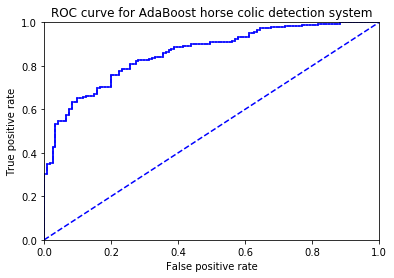

the Area Under the Curve is:  0.8582969635063604


In [85]:
plotROC(aggClassEst.T , labelArr)